In [1]:
import numpy as np
import ciropt as co

np.random.seed(1)

In [2]:
problem = co.CircuitOpt()

In [3]:
mu = 1
M = np.inf
f = co.def_function(problem, mu, M)

In [4]:
x_star, y_star, f_star = f.stationary_point(return_gradient_and_function_value=True)

In [5]:
h, b, d = problem.h, problem.b, problem.d

In [6]:
R, C = 1, 10


z_1 = problem.set_initial_point()
e2_1 = problem.set_initial_point()
x_1 = co.proximal_step(z_1, f, R/2)[0]
y_1 = (2 / R) * (z_1 - x_1)


e2_2 = e2_1  -  h / (2 * R * C) *  (R * y_1 + 3 * e2_1)  
z_2 = z_1  -  h / (4 * R * C) *  (5 * R * y_1 + 3 * e2_1)
x_2 = co.proximal_step(z_2, f, R/2)[0]
y_2 = (2 / R) * (z_2 - x_2)

v_C1_1 = e2_1 / 2 - z_1
v_C1_2 = e2_2 / 2 - z_2
v_C2_1 = e2_1; v_C2_2 = e2_2 
e1_1 = (e2_1 - R * y_1) / 2

In [7]:
E_1 = (C/2) * (v_C1_1 + x_star)**2 + (C/2) * (v_C2_1)**2
E_2 = (C/2) * (v_C1_2 + x_star)**2 + (C/2) * (v_C2_2)**2
Delta_1 = b * (x_1 - x_star) * (y_1 - y_star) \
        + d * (1/R) * ((e1_1)**2 + (e1_1 - e2_1)**2 + (e2_1)**2)


problem.set_performance_metric(E_2 - (E_1 - Delta_1))

In [8]:
problem.obj = problem.b + problem.d * 1.1

params, sol = problem.solve(solver="ipopt", verbose=False)[:2]

dim_G=5, dim_F=3
Ipopt total # of variables = 42
Actual # of variables = 31


In [9]:
params

{'b': 6.3636363503350255, 'h': 6.3636363397101166, 'd': 0.28925619727561686}

$$
\begin{array}{ll}
\text{minimize} & f(x) = \|x\|_1 + \frac{1}{2}\|x\|_2^2 \\
\end{array}
$$

In [10]:
import cvxpy as cp
import matplotlib.pyplot as plt

In [22]:
def prox_oracle_cvx(n, R, tilde_x):
    x = cp.Variable(n) 
    f = cp.norm(x, p=1) + cp.sum_squares(x)
    objective = cp.Minimize(f + (1/(2*R)) * cp.sum_squares(x - tilde_x))
    prob = cp.Problem(objective, [])
    prob.solve()
    return x.value


def prox_oracle(n, R, tilde_x):
    x = np.multiply(np.sign(tilde_x.flatten()), np.maximum(0, np.abs(tilde_x.flatten()) - R)) / (R+1)
    return x

In [27]:
np.sign(np.random.randn(10))

array([ 1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.])

In [24]:
n = 100
f_star = 0

In [32]:
losses = []
z_0 = np.random.randn(n) * 10
e2_0 = np.zeros(n)
for k in range(10):
    x1 = prox_oracle_cvx(n, R/2, z_0)
    g_x1 = (2 / R) * (z_0 - x1)
    e2_1 = e2_0 - params["h"] / (2 * R * C) * (R * g_x1 + 3 * e2_0)
    z_1 = z_0 - params["h"] / (4 * R * C) * (5 * R * g_x1 + 3 * e2_0)
    losses += [np.linalg.norm(x1, ord=1) + np.linalg.norm(x1, ord=2)**2]
    e2_0 = e2_1
    z_0 = z_1
    print(losses[-1])

print(f"{losses[-1]=}, {f_star=}")

2965.8522725071907
106.10765174776056
93.53400268894318
6.789860184615801
0.9084484281863237
3.0480143989869722e-21
2.4673888419334204e-21
2.5110865624652965e-21
2.7724362761310333e-21
3.0788665531676105e-21
losses[-1]=3.0788665531676105e-21, f_star=0


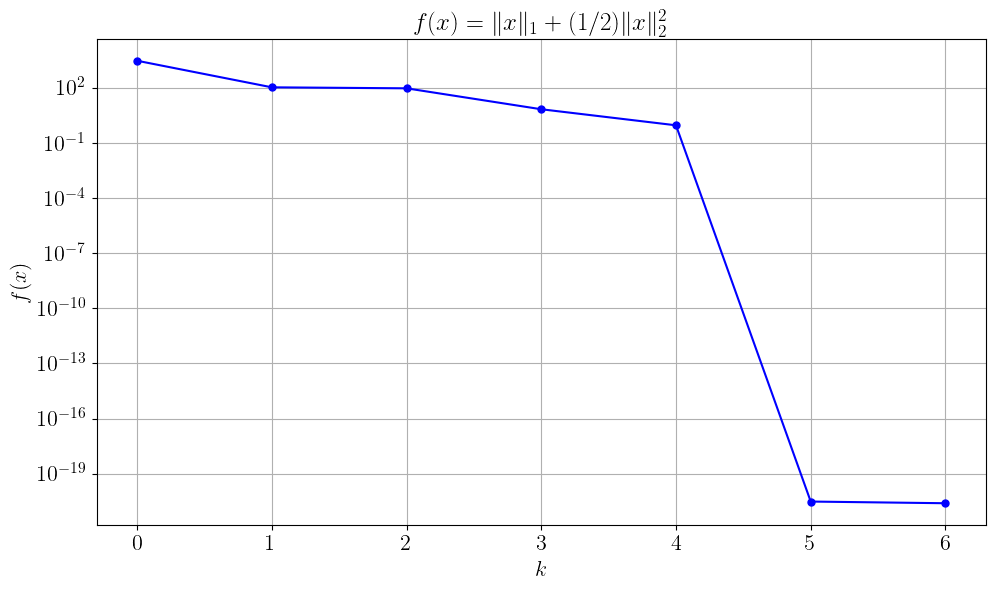

In [36]:
plt.figure(figsize=(10, 6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(losses[:7], label=r'$f(x^k)$', color='blue', marker='o', ms=5)
# plt.axhline(y=f_star, color='red', linestyle='-', label=r"$f^\star$") 

plt.title(r'$f(x)=\|x\|_1 + (1/2)\|x\|^2_2$', fontsize=18, fontname='serif')
plt.xlabel(r'$k$', fontsize=16)
plt.ylabel(r"$f(x)$", fontsize=16)
# plt.legend(fontsize=16) 
plt.xticks(fontsize=16, fontname='serif')
plt.yticks(fontsize=16, fontname='serif')
# plt.legend(fontsize=16) 
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.savefig(f'figures/simple_hello_wrld.pdf')
plt.show()